In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.express as px
from math import floor
from sklearn.model_selection import train_test_split

1. PICO formulation

Suggestion:

**Population** : diagnosed diabetic and HbA1c tested population ; \
**Intervention** : HbA1c test (allowing being adequately diagnosed as diabetic) ; \
**Comparaison** : diagnosed diabetic without being tested ; \
**Résultat** : readmission (<30days).

Why would a patient be early readmitted in the first place? Here are a few hypotheses:

Patient is not adequately diagnosed as diabetic on the first admission;
Ineffectiveness of treatment during past hospitalizations, namely
insufficient number of exams;
insufficient medical intervention (medication change or procedures);
Poor patient health.

The data set used for this task is the Diabetes 130-US hospitals for years 1999-2008 Data Set, containing anonymized medical data collected during 100k encounters across several hospitals in the United States, made available by Strack et al. (2014).

2. Exploratory data analysis

Documentation of the database can be found here: https://github.com/uci-ml-repo/ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets
ID = diabetes_130_us_hospitals_for_years_1999_2008.data.ids
df = pd.concat([ID, X, y], axis=1)

# metadata
print(diabetes_130_us_hospitals_for_years_1999_2008.metadata)

# variable information
print(diabetes_130_us_hospitals_for_years_1999_2008.variables)

/usr/local/lib/python3.11/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 296, 'name': 'Diabetes 130-US Hospitals for Years 1999-2008', 'repository_url': 'https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008', 'data_url': 'https://archive.ics.uci.edu/static/public/296/data.csv', 'abstract': 'The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the early readmission of the patient within 30 days of discharge.\nThe problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide pro

In [4]:
print(diabetes_130_us_hospitals_for_years_1999_2008.data.targets.value_counts(normalize=True))

readmitted
NO            0.539119
>30           0.349282
<30           0.111599
Name: proportion, dtype: float64


Our study focuses on readmission ("<30") representing 11% of the sample. Our aim will be to measure the impact of HbA1c measurement on readmission.
HbA1c not only provides a reliable measure of chronic hyperglycemia, but is also well correlated with the risk of long-term diabetes complications. It is therefore crucial for a correct diagnosis.


Source: https://translate.google.com/translate?u=https://pmc.ncbi.nlm.nih.gov/articles/PMC4933534/&hl=fr&sl=en&tl=fr&client=rq&prev=search#:~:text=HbA1c%20not%20only%20provides%20a,subjects%20with%20or%20without%20diabetes

In [5]:
print("Variable              Unique     % Missing  Examples")
print("="*100)
for column in df:
    uniques = set(df[column])
    n_uniques = len(uniques)
    missing = df[column].isnull().mean()*100
    examples = list(uniques)[:5]
    output = "{:<25} {:<10} {:<6.1f} {:<20}".format(column, n_uniques, missing, str(examples))
    print(output)

Variable              Unique     % Missing  Examples
encounter_id              101766     0.0    [77856768, 173015040, 84934662, 273678342, 17563668]
patient_nbr               71518      0.0    [33947649, 92667906, 82706436, 83623941, 128319494]
race                      6          2.2    ['AfricanAmerican', 'Hispanic', 'Asian', nan, 'Other']
gender                    3          0.0    ['Unknown/Invalid', 'Female', 'Male']
age                       10         0.0    ['[30-40)', '[20-30)', '[10-20)', '[90-100)', '[50-60)']
weight                    10         96.9   ['[25-50)', '[50-75)', '[75-100)', '>200', nan]
admission_type_id         8          0.0    [1, 2, 3, 4, 5]     
discharge_disposition_id  26         0.0    [1, 2, 3, 4, 5]     
admission_source_id       17         0.0    [1, 2, 3, 4, 5]     
time_in_hospital          14         0.0    [1, 2, 3, 4, 5]     
payer_code                16402      39.6   [nan, nan, nan, nan, nan]
medical_specialty         73         49.1   ['Inte

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [7]:
n_uniqueindiv = df['patient_nbr'].nunique()
n_uniqueencounter = df['patient_nbr'].count()
print(f"Among the {n_uniqueencounter} observations, there are {n_uniqueindiv} unique individuals")

Among the 101766 observations, there are 71518 unique individuals


In [8]:
# Keeping the original df intact in case we need it
df2 = df.copy()

[REFORMULATE] A few rows in the data set refer to the same patient number (patient_nbr). To ensure our model's robustness, and avoid overweighting readmitted patients in descriptive statistics, duplicated entries for the same patient will be deleted (while keeping the first appearance only).

In [9]:
#print("df size before:", df.shape[0])
df2 = df2.drop_duplicates(subset="patient_nbr", keep="first")
print("df size after:", df2.shape[0])

df size after: 71518


In [10]:
race = pd.DataFrame(df2['race'])
fig = px.pie(race, names='race', title='Distribution of Race')
fig.show()

age = pd.DataFrame(df2['age'])
fig = px.pie(age, names='age', title='Distribution of Age')
fig.show()

gender = pd.DataFrame(df2['gender'])
fig = px.pie(gender, names='gender', title='Distribution of Gender')
fig.show()

weight = pd.DataFrame(df2['weight'])
fig = px.pie(weight, names='weight', title='Distribution of Weight')
fig.show()

In [11]:
readmitted_age = df[df["readmitted"] == "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

readmitted_age

,proportion
age,
[0-10),0.000264
[10-20),0.003522
[20-30),0.020780
[90-100),0.027296
[30-40),0.037334
[40-50),0.090429
[50-60),0.146870
[80-90),0.182971
[60-70),0.220305


In [12]:
nonreadmitted_age = df[df["readmitted"] != "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nonreadmitted_age

,proportion
age,
[0-10),0.001748
[10-20),0.007201
[20-30),0.015717
[90-100),0.027464
[30-40),0.037065
[40-50),0.095765
[80-90),0.167229
[50-60),0.172416
[60-70),0.221007


In [13]:
nonreadmitted_age = df[df["readmitted"] != "<30"]["age"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nonreadmitted_age

,proportion
age,
[0-10),0.001748
[10-20),0.007201
[20-30),0.015717
[90-100),0.027464
[30-40),0.037065
[40-50),0.095765
[80-90),0.167229
[50-60),0.172416
[60-70),0.221007


In [ ]:
# Create directory to save figs
#import os

# Create a directory named 'figures' if it doesn't exist
#if not os.path.exists('figures'):
#    os.makedirs('figures')

# Save your figure
#plt.savefig('figures/topage.png')

FileNotFoundError: [Errno 2] No such file or directory: 'figures/topage.png'

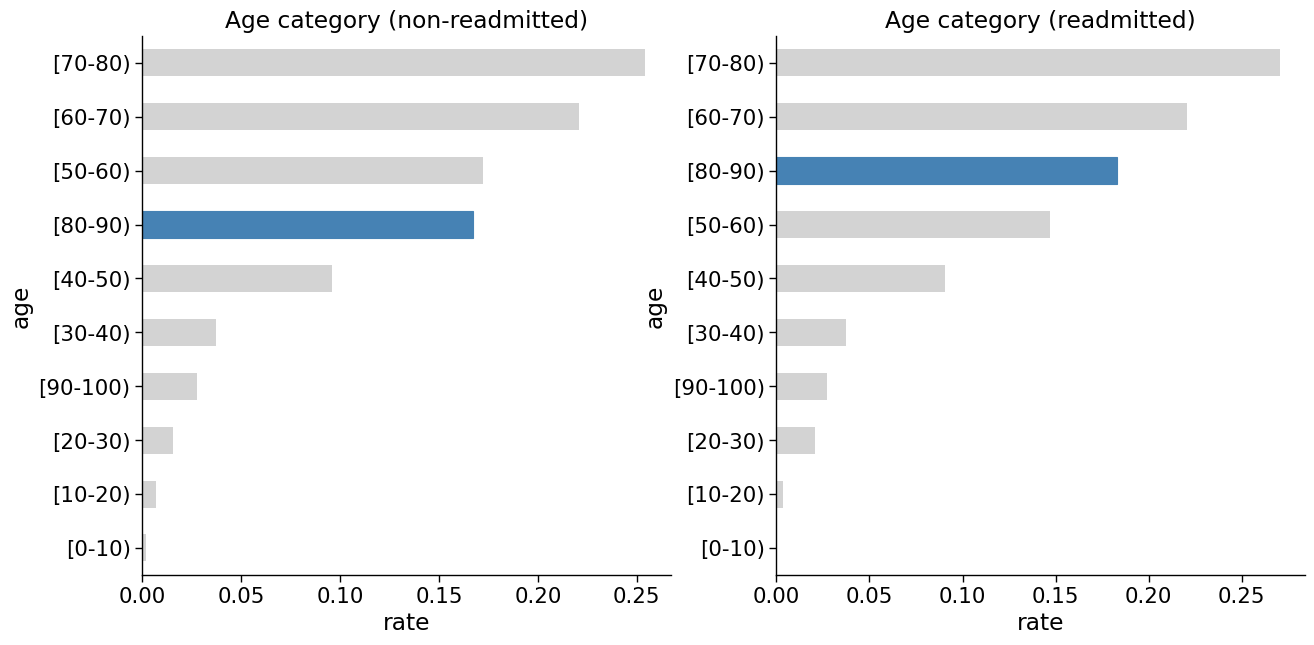

In [14]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nonreadmitted_age.plot(kind="barh", title="Age category (non-readmitted)", color="lightgray", ax=ax1)
readmitted_age.plot(kind="barh", title="Age category (readmitted)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

ax1.patches[6].set_color("steelblue")
ax2.patches[7].set_color("steelblue")

sns.despine()

plt.savefig("figures/topage.png")
plt.show()

In the analysis, one should keep in mind than multiple factors drive readmission, independently from individuals being HbA1c tested or not

In [15]:
#Generate dummy variable being 1 when A1C tested
df2['A1C_tested'] = 1 - df2['A1Cresult'].isna()
df2['max_glu_serum_tested'] = 1 - df2['max_glu_serum'].isna()


In [16]:
nontested_diag1 = df2[df2["A1C_tested"] != 1]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

nontested_diag1

,proportion
diag_1,
491,0.018437
780,0.019172
434,0.019667
427,0.029219
715,0.030244
486,0.034635
410,0.037609
786,0.040001
428,0.054371


In [17]:
tested_diag1 = df2[df2["A1C_tested"] == 1]["diag_1"] \
    .value_counts(ascending=True, normalize=True) \
    .tail(10)

tested_diag1

,proportion
diag_1,
250.8,0.022491
780,0.023030
427,0.026419
486,0.031734
682,0.032812
434,0.033120
786,0.053840
410,0.053994
428,0.061465


FileNotFoundError: [Errno 2] No such file or directory: 'figures/top10diagnoses.png'

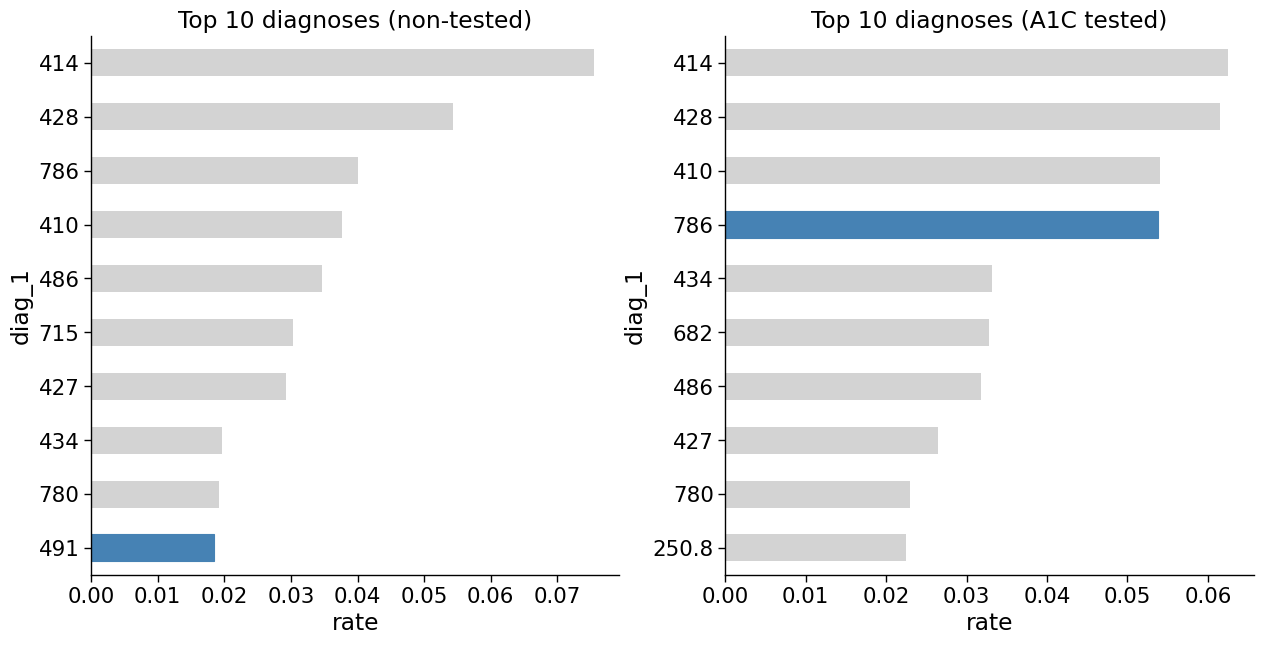

In [18]:
sns.set_context('paper', font_scale=1.75)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))

nontested_diag1.plot(kind="barh", title="Top 10 diagnoses (non-tested)", color="lightgray", ax=ax1)
tested_diag1.plot(kind="barh", title="Top 10 diagnoses (A1C tested)", color="lightgray", ax=ax2)

ax1.set_xlabel("rate")
ax2.set_xlabel("rate")

#[TODO] change diagnoses in blue (find relevant ones)
ax1.patches[0].set_color("steelblue")
ax2.patches[6].set_color("steelblue")

#ax1.text(x=0.022,y=0-0.14,s="general symptoms")
#ax2.text(x=0.032,y=6-0.14,s="occlusion of cerebral arteries")

sns.despine()

plt.savefig("figures/top10diagnoses.png")
plt.show()

3. Data processing

[REFORMULATE] There were several
features that could not be treated directly since they had
a high percentage of missing values. These features were
weight (97% values missing), payer code (40%), and medical
specialty (47%). Weight attribute was considered to be too
sparse and it was not included in further analysis. Payer
code was removed since it had a high percentage of missing
values and it was not considered relevant to the outcome.
Medical specialty attribute was maintained, adding the value
“missing” in order to account for missing values.

In [19]:
df2 = df2.drop(["encounter_id",
                "patient_nbr",
                "payer_code",
                "weight",
                "medical_specialty",
                "admission_source_id",
                "metformin",
                "glimepiride",
                "glipizide",
                "glyburide",
                "pioglitazone",
                "rosiglitazone",
                "insulin",
                "repaglinide",
                "nateglinide",
                "chlorpropamide",
                "acetohexamide",
                "tolbutamide",
                "acarbose",
                "miglitol",
                "troglitazone",
                "tolazamide",
                "examide",
                "citoglipton",
                "glyburide-metformin",
                "glipizide-metformin",
                "glimepiride-pioglitazone",
                "metformin-rosiglitazone",
                "metformin-pioglitazone",
                ], axis=1)

In [20]:
df2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted', 'A1C_tested', 'max_glu_serum_tested'],
      dtype='object')

[REFORMULATE] Age \
The age group feature in this data set is categorical, but can be turned into an ordinal variable. That way we avoid creating too many new features after the one-hot encoding process.

In [21]:
age_map = {'[0-10)': 0,
           '[10-20)': 1,
           '[20-30)': 2,
           '[30-40)': 3,
           '[40-50)': 4,
           '[50-60)': 5,
           '[60-70)': 6,
           '[70-80)': 7,
           '[80-90)': 8,
           '[90-100)': 9}

df2["age"].replace(age_map, inplace=True)

<ipython-input-21-6f6e985e54eb>:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-21-6f6e985e54eb>:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



[REFORMULATE] Gender \
Gender will be converted to either 0 if male or 1 if female.

In [22]:
df2["gender"] = df2["gender"].apply(lambda x: 1 if x == "Female" else 0)

[REFORMULATE] Admission type \
Group this feature by whether patients were admitted in an emergency or not. Thus, "Emergency" (which includes "Urgent") will become 1 and everything else will be 0.

In [23]:
df2["emergency"] = df2["admission_type_id"].apply(lambda x: 1 if x in [1, 2] else 0)
df2.drop("admission_type_id", axis=1, inplace=True)

[REFORMULATE] Discharge disposition ID \
This feature has 29 distinct features, which would negatively impact the model's performance if we create dummy values for all of them. Therefore, I'm going to restrict these values to either "discharged to home" or other.

In [24]:
df2["sent_home"] = df2["discharge_disposition_id"].apply(lambda x: 1 if x in [1, 6, 8] else 0)
df2.drop("discharge_disposition_id", axis=1, inplace=True)

[REFORMULATE] Diagnosis \
The diagnosis features are represented by ICD-9 codes. The idea here is to condensate the hundreds of codes into just a few major groups, based on field knowledge (Strack et al., 2014). I also made sure to include the diagnoses that were among the top 10 for readmitted patients but not for non-readmitted, and vice-versa.

In [25]:
# Make it easier to enter ICD-9 ranges in the dictionary
interval = lambda x,y: list(range(x,y+1))

diag = {
    "Circulatory": interval(390, 433) + interval(435, 459) + [785],  # except 434
    "Respiratory": interval(460,519) + [786],
    "Digestive": interval(520,579) + [786],
    "Diabetes": [250],  # makes sense to give Diabetes a group for its own
    "Injury": interval(800,999),
    "Musculoskeletal": interval(710,739),
    "Genitourinary": interval(580,629) + [788],
    "Neoplasms": interval(140,239),
    "Endocrine": interval(240,249) + interval(251,279),  # except 250
    "General symptoms": [780,781,784] + interval(790,799),  # among thedupl top 10 for non-readmitted
    "Skin": interval(680,709) + [782],
    "Infection": interval(1,139),
    "Mental": interval(290,319),
    "External causes": [1000],  # passed by icd() as 1000, but the code doesn't exist officially
    "Blood": interval(280,289),
    "Nervous": interval(320,359),
    "Pregnancy": interval(630,679),
    "Sense organs": interval(360,389),
    "Congenital": interval(740, 759),
    "Occlusion of cerebral arteries": [434], # among the top 10 for readmitted
    "Unknown": [-1]
}

def icd(code):
    """Converts ICD-9 code in string format into a descriptive major category.
    ---
    code : int
    The ICD-9 encoded diagonisis

    return : str
    A major diagnostic category.
    """
    if (code[0] != "V") and (code[0] != "E"):
        code = floor(float(code))
    else:
        code = 1000
    for key in diag:
        if code in diag[key]:
            return key

In [26]:
df2["diag_1"] = df2["diag_1"].fillna("-1").apply(icd)
df2["diag_2"] = df2["diag_2"].fillna("-1").apply(icd)
df2["diag_3"] = df2["diag_3"].fillna("-1").apply(icd)

[REFORMULATE] Glucose serum test result (max_glu_serum) and A1c test \
This variable indicates the range of the test results, or whether the tests were taken at all. It could be be converted into an ordinal variable and spare the creation of unnecessary dummy features.

In [27]:
df2["A1Cresult"] = df2["A1Cresult"].fillna("None")
df2["max_glu_serum"] = df2["max_glu_serum"].fillna("None")

In [28]:
df2["A1Cresult_ord"] = df2["A1Cresult"].map({"None": -1, "Norm": 0, ">7": 1, ">8": 2})
df2["max_glu_serum_ord"] = df2["max_glu_serum"].map({"None": -1, "Norm": 0, ">200": 1, ">300": 2})

Change of medication / Diabetes medications \
Converting object type to numerical:

In [29]:
df2["change"] = df2["change"].apply(lambda x: 1 if x == "Ch" else 0)

In [30]:
df2["diabetesMed"] = df2["diabetesMed"].apply(lambda x: 1 if x == "Yes" else 0)

Readmitted (target variable)
Setting the variable to 1 if readmitted earlier than 30 days, 0 otherwise.

In [31]:
df2['readmitted'] = df2['readmitted'].apply(lambda x: 1 if x == "<30" else 0)

Dummy variables creation
All categorical variables are going to be converted into dummy variables (one-hot encoding).

In [32]:
# Drop the specified columns if they exist
columns_to_drop = ['A1Cresult', 'max_glu_serum']
df2_simpl = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns])

In [33]:
# Apply pd.get_dummies() to the dataframe
df3 = pd.get_dummies(df2_simpl, dummy_na=False, drop_first=False)

Merging diag_n variables \

The diag features represent what the physician thought would be the causes of the patient admission. As a rule, the primary (principal) cause of admission should be the diag_1 variable. diag_2 and diag_3 variables are left for secondary causes. To avoid passing too many dummy variables to the model, I'm going to merge the three features into a weighted sum. \

Example: if a patient has diag_1_Circulatory = 1, diag_2_Circulatory = 1, and diag_3_Circulatory = 0, the weighted sum is going to be diag_Circulatory = 1x3 + 1x2 + 0x1 = 5.

In [34]:
for disease in diag:
    df3[f"diag_{disease}"] = df3[f"diag_1_{disease}"]*3 + df3[f"diag_2_{disease}"]*2 + df3[f"diag_3_{disease}"]*1
    df3.drop([f"diag_{n}_{disease}" for n in range(1,4)], axis=1, inplace=True)

In [35]:
df3.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'diabetesMed', 'readmitted', 'A1C_tested', 'max_glu_serum_tested',
       'emergency', 'sent_home', 'A1Cresult_ord', 'max_glu_serum_ord',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_Circulatory', 'diag_Respiratory', 'diag_Digestive',
       'diag_Diabetes', 'diag_Injury', 'diag_Musculoskeletal',
       'diag_Genitourinary', 'diag_Neoplasms', 'diag_Endocrine',
       'diag_General symptoms', 'diag_Skin', 'diag_Infection', 'diag_Mental',
       'diag_External causes', 'diag_Blood', 'diag_Nervous', 'diag_Pregnancy',
       'diag_Sense organs', 'diag_Congenital',
       'diag_Occlusion of cerebral arteries', 'diag_Unknown'],
      dtype='object')

TODO: add correlation of DiabMed & HbA1c test/results

In [36]:
# Compute the correlation between 'diabetesMed' and 'A1C_tested'
correlation_A1C_tested = df3['diabetesMed'].corr(df3['A1C_tested'])
# Compute the correlation between 'diabetesMed' and 'A1Cresult_ord'
correlation_A1Cresult_ord = df3['diabetesMed'].corr(df3['A1Cresult_ord'])

print("Correlation between 'diabetesMed' and 'A1C_tested':", correlation_A1C_tested)
print("Correlation between 'diabetesMed' and 'A1Cresult_ord':", correlation_A1Cresult_ord)


Correlation between 'diabetesMed' and 'A1C_tested': 0.07578344706759124
Correlation between 'diabetesMed' and 'A1Cresult_ord': 0.09926422181702693


In [37]:
abscorr = df3.corr().abs()
corr_list = abscorr.unstack().sort_values(kind="quicksort", ascending=False)
corr_list[(corr_list > 0.5) & (corr_list != 1)]

,,0
A1C_tested,A1Cresult_ord,0.917508
A1Cresult_ord,A1C_tested,0.917508
max_glu_serum_tested,max_glu_serum_ord,0.902445
max_glu_serum_ord,max_glu_serum_tested,0.902445
race_AfricanAmerican,race_Caucasian,0.807590
race_Caucasian,race_AfricanAmerican,0.807590
change,diabetesMed,0.506697
diabetesMed,change,0.506697


In [38]:
df3.columns

Index(['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'change',
       'diabetesMed', 'readmitted', 'A1C_tested', 'max_glu_serum_tested',
       'emergency', 'sent_home', 'A1Cresult_ord', 'max_glu_serum_ord',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_Circulatory', 'diag_Respiratory', 'diag_Digestive',
       'diag_Diabetes', 'diag_Injury', 'diag_Musculoskeletal',
       'diag_Genitourinary', 'diag_Neoplasms', 'diag_Endocrine',
       'diag_General symptoms', 'diag_Skin', 'diag_Infection', 'diag_Mental',
       'diag_External causes', 'diag_Blood', 'diag_Nervous', 'diag_Pregnancy',
       'diag_Sense organs', 'diag_Congenital',
       'diag_Occlusion of cerebral arteries', 'diag_Unknown'],
      dtype='object')

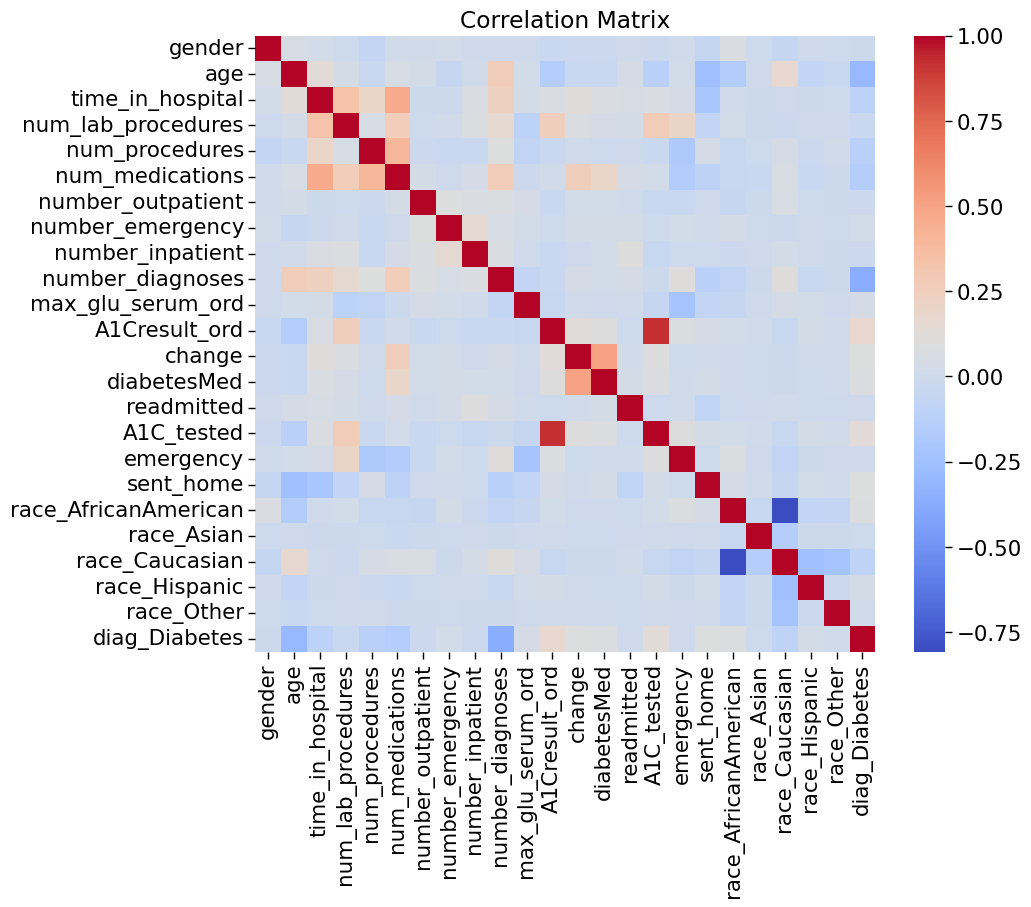

In [39]:
variables = ['gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum_ord', 'A1Cresult_ord', 'change', 'diabetesMed', 'readmitted',
       'A1C_tested', 'emergency', 'sent_home',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'diag_Diabetes']

correlation_matrix = df3[variables].corr()
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

According to the data set, some patients diagnosed with diabetes didn't have their HbA1c levels checked to see wether medication was adapted, and those were more likely of being readmitted within 30 days.

In [40]:
share_diag_diabetes_not_tested = df3[(df3.diag_Diabetes > 0) & (df3.A1C_tested == 0)].shape[0] / df3[df3.diag_Diabetes > 0].shape[0]
print(f"Share of patients diagnosed with diabetes but not tested for A1C: {share_diag_diabetes_not_tested * 100:.2f}%")

Share of patients diagnosed with diabetes but not tested for A1C: 77.41%


In [41]:
# Share of readmitted among those diagnosed with diabetes and tested for A1C results
share_tested = df3[(df3.diag_Diabetes > 0) & (df3.A1C_tested == 1)]['readmitted'].mean()

# Share of readmitted among those diagnosed with diabetes and not tested for A1C results
share_not_tested = df3[(df3.diag_Diabetes > 0) & (df3.A1C_tested == 0)]['readmitted'].mean()

print(f"Share of readmitted (A1C tested): {share_tested * 100:.2f}%")
print(f"Share of readmitted (A1C not tested): {share_not_tested * 100:.2f}%")

Share of readmitted (A1C tested): 7.79%
Share of readmitted (A1C not tested): 8.73%


High HbA1c levels is one of the key indicators of inadapted diabetes medication. The data shows that once A1c levels are assessed, a medication change is more likely to occur.

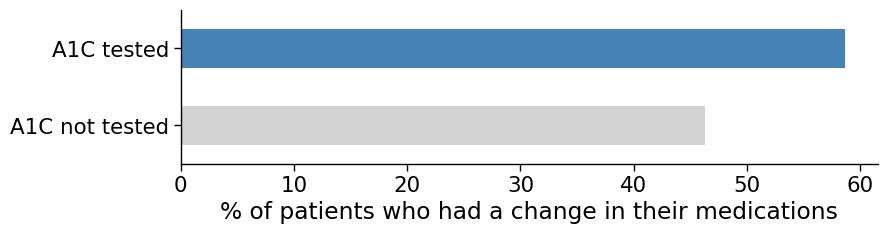

In [42]:
plt.figure(figsize=(9,2))
(df3[(df3.diag_Diabetes > 0)].groupby("A1C_tested")['change'].mean()*100).plot.barh(color=["lightgray", "steelblue"])
plt.xlabel("% of patients who had a change in their medications")
plt.yticks(ticks=[0,1], labels=["A1C not tested", "A1C tested"])
plt.ylabel(None)
sns.despine()

Causal analysis requires controling for potential cofounding factors such as [TODO] correlated with both A1C test probability and long term health issues (outcome variable).

[INCOMPLETE] DAG & variable choice
In particular, what I had in mind is to check the main covariates both impacting D and T (and store the rest in Other)
So the next step would be to find these variables

In [43]:
import networkx as nx
from pgmpy.base.DAG import DAG

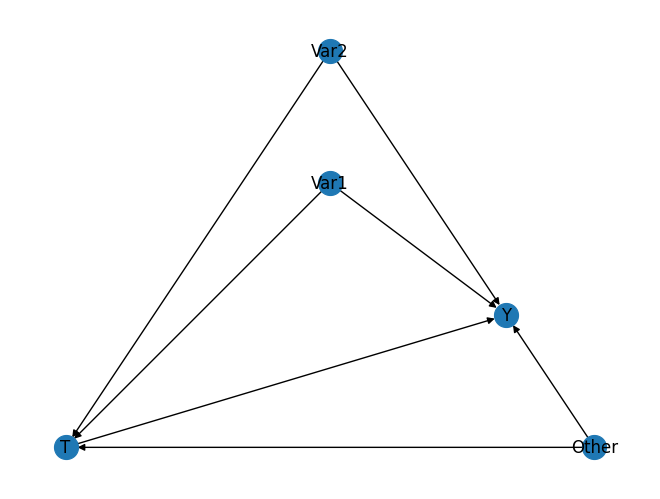

In [44]:
digraph = nx.DiGraph(
    [
        ("T", "Y"),
        ("Var1", "T"),
        ("Var2", "T"),
        ("Var1", "T"),
        ("Var1", "T"),
        ("Var1", "T"),
        ("Other", "T"),
        ("Var1", "Y"),
        ("Var2", "Y"),
        ("Var1", "Y"),
        ("Var1", "Y"),
        ("Var1", "Y"),
        ("Other", "Y"),
    ]
)
G = DAG(digraph)
nx.draw_planar(G, with_labels=True)
plt.show()

4. Model for impact evaluation

In [1]:
from doubleml import DoubleMLData
import doubleml as dml
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [45]:
x_cols = df3.columns.tolist()
x_cols.remove('readmitted')
x_cols.remove('A1C_tested')
x_cols.remove('A1Cresult_ord')

dml_data = DoubleMLData(df3,
    y_col='readmitted',
    d_cols='A1C_tested',
    x_cols=x_cols)

[TODO] detail hypothesis of the model: the PLR assumes a partially linear structure
Because we have a binary treatment AND OUTCOME variables, we can use a classification learners.
[TODO]think about wether we use a regression learner for the binary outcome variable

[REFORMULATE] Estimation of the nuisance components and , is based on the lasso with cross-validated choice of the penalty term ,  , as provided by scikit-learn. We load the learner by initializing instances from the classes LassoCV and LogisticRegressionCV. Hyperparameters and options can be set during instantiation of the learner. Here we specify that the lasso should use that value of that minimizes the cross-validated mean squared error which is based on 5-fold cross validation.

$$
\begin{align*}
g_0(x) &= \mathbb{E}[Y X=x, D=0] \\
g_1(x) &= \mathbb{E}[Y|X=x, D=1] \\
m(x) &= \mathbb{E}[D|X=x] \\
\end{align*}
$$

In [46]:
from sklearn.linear_model import LogisticRegression

ml_g_linear = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)
ml_m_linear = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)

dml_plr_obj = dml.DoubleMLIRM(dml_data,
                              ml_g=ml_g_linear,
                              ml_m=ml_m_linear)


print(dml_plr_obj.fit().summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef  std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.004319  0.00369 -1.170236  0.241906 -0.011552  0.002914


In [ ]:
from sklearn.metrics import log_loss, balanced_accuracy_score
def logloss(y_true, y_pred):
    subset = np.logical_not(np.isnan(y_true))
    return log_loss(y_true[subset], y_pred[subset])

In [ ]:
# Random Forest
randomForest_class = RandomForestClassifier()

np.random.seed(123)
dml_irm_forest = dml.DoubleMLIRM(dml_data,
                                 ml_g = randomForest_class,
                                 ml_m = randomForest_class,
                                 n_folds = 5)


dml_irm_forest.fit(store_predictions=True)
forest_summary = dml_irm_forest.summary

print(forest_summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.001688  0.004138 -0.407972  0.683294 -0.009799  0.006422


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning:

Propensity predictions from learner RandomForestClassifier() for ml_m are close to zero or one (eps=1e-12).



In [ ]:
print(f'Linear nuisance functions:\n{dml_irm_forest.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[0.31730067]]), 'ml_g1': array([[0.31683519]]), 'ml_m': array([[0.41219855]])}


In [ ]:
#Approx 25 features in the model

param_grid = {
    'ml_g': {
    'n_estimators': [100, 300],  # Fewer trees to reduce computation
    'max_depth': [6, 10],  # Limit tree depth
    'min_samples_leaf': [5, 10],  # Prevent overfitting
    'max_features': ['sqrt', 10]  # Feature selection per split
    },
    'ml_m': {
    'n_estimators': [100, 300],  # Fewer trees to reduce computation
    'max_depth': [6, 10],  # Limit tree depth
    'min_samples_leaf': [5, 10],  # Prevent overfitting
    'max_features': ['sqrt', 10]  # Feature selection per split
    }
}

# Tune the model
dml_irm_forest.tune(param_grid, search_mode='grid_search')
dml_irm_forest.fit(store_predictions=True)
forest_summary = dml_irm_forest.summary

print(forest_summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.005159  0.002774 -1.859559  0.062948 -0.010597  0.000279


In [ ]:
print(f'Linear nuisance functions:\n{dml_irm_forest.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[0.29213184]]), 'ml_g1': array([[0.27806635]]), 'ml_m': array([[0.40701428]])}


In [ ]:
# Trees
trees_class = DecisionTreeClassifier()

np.random.seed(123)
dml_irm_tree = dml.DoubleMLIRM(dml_data,
                               ml_g = trees_class,
                               ml_m = trees_class,
                               n_folds = 5)

dml_irm_tree.fit(store_predictions=True)
tree_summary = dml_irm_tree.summary

print(tree_summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested  0.203851  0.079066  2.578227  0.009931  0.048884  0.358818


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning:

Propensity predictions from learner DecisionTreeClassifier() for ml_m are close to zero or one (eps=1e-12).



In [ ]:
print(f'Linear nuisance functions:\n{dml_irm_tree.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[6.08651957]]), 'ml_g1': array([[5.76775743]]), 'ml_m': array([[1.21707404]])}


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'ml_g': {
    'max_depth': [6, 10],  # Balanced depth
    'min_samples_split': [20, 50],  # Prevents over-splitting
    'min_samples_leaf': [10, 20],  # Controls leaf size
    'ccp_alpha': [0.0, 0.01]  # Light pruning
    },
    'ml_m': {
    'max_depth': [6, 10],  # Balanced depth
    'min_samples_split': [20, 50],  # Prevents over-splitting
    'min_samples_leaf': [10, 20],  # Controls leaf size
    'ccp_alpha': [0.0, 0.01]  # Light pruning
    }
}


# Tune the model using grid search
dml_irm_tree.tune(param_grid, search_mode='grid_search')

# Fit the model with the best parameters
dml_irm_tree.fit(store_predictions=True)

# Get the summary of the tuned model
tree_summary = dml_irm_tree.summary
print(tree_summary)

               coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.00924  0.003346 -2.761643  0.005751 -0.015798 -0.002682


c:\Users\Mhammedi\CausalML-HospitalReadmission\.venv\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning:

Propensity predictions from learner DecisionTreeClassifier() for ml_m are close to zero or one (eps=1e-12).



In [ ]:
print(f'Linear nuisance functions:\n{dml_irm_tree.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[0.30042273]]), 'ml_g1': array([[0.28651451]]), 'ml_m': array([[0.4183149]])}


In [ ]:
# Boosted Trees
boost_class = XGBClassifier(n_jobs=1, objective = "binary:logistic", eval_metric = "logloss")

np.random.seed(123)
dml_irm_boost = dml.DoubleMLIRM(dml_data,
                                ml_g = boost_class,
                                ml_m = boost_class,
                                n_folds = 5)

dml_irm_boost.fit(store_predictions=True)
boost_summary = dml_irm_boost.summary

print(boost_summary)

                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.004971  0.004845 -1.026164  0.304814 -0.014467  0.004524


In [ ]:
print(f'Linear nuisance functions:\n{dml_irm_boost.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[0.29897099]]), 'ml_g1': array([[0.31053542]]), 'ml_m': array([[0.40531846]])}


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'ml_g': {
    'n_estimators': [100, 300],  # Limit boosting rounds
    'max_depth': [3, 6],  # Prevent deep trees
    'learning_rate': [0.01, 0.1],  # Conservative learning rate
    'subsample': [0.8, 1.0],  # Avoid overfitting
    'colsample_bytree': [0.8, 1.0]  # Control feature selection
    },
    'ml_m': {
    'n_estimators': [100, 300],  # Limit boosting rounds
    'max_depth': [3, 6],  # Prevent deep trees
    'learning_rate': [0.01, 0.1],  # Conservative learning rate
    'subsample': [0.8, 1.0],  # Avoid overfitting
    'colsample_bytree': [0.8, 1.0]  # Control feature selection
    }
}

# Tune the model using grid search
dml_irm_boost.tune(param_grid, search_mode='grid_search')

# Fit the model with the best parameters
dml_irm_boost.fit(store_predictions=True)

# Get the summary of the tuned model
boost_summary = dml_irm_boost.summary
print(boost_summary)

                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.004509  0.003753 -1.201457  0.229574 -0.011864  0.002846


In [ ]:

print(f'Linear nuisance functions:\n{dml_irm_boost.evaluate_learners(metric=logloss)}')

Linear nuisance functions:
{'ml_g0': array([[0.29065018]]), 'ml_g1': array([[0.27803224]]), 'ml_m': array([[0.40011842]])}


In [ ]:
plr_summary = pd.concat((tree_summary, forest_summary, boost_summary))
plr_summary.index = ['tree', 'forest', 'xgboost']
print(plr_summary[['coef', '2.5 %', '97.5 %']])

             coef     2.5 %    97.5 %
tree    -0.009240 -0.015798 -0.002682
forest  -0.005159 -0.010597  0.000279
xgboost -0.004509 -0.011864  0.002846


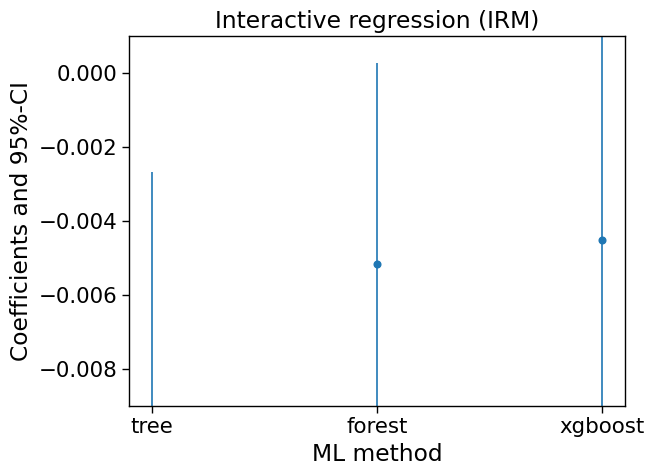

In [ ]:
errors = np.full((2, plr_summary.shape[0]), np.nan)
errors[0, :] = plr_summary['coef'] - plr_summary['2.5 %']
errors[1, :] = plr_summary['97.5 %'] - plr_summary['coef']
plt.errorbar(plr_summary.index, plr_summary.coef, fmt='o', yerr=errors)
plt.ylim([-0.009, 0.001])

plt.title('Interactive regression (IRM)')
plt.xlabel('ML method')
_ =  plt.ylabel('Coefficients and 95%-CI')

## Heterogenous treatment effects

 We aim to investigate whether the treatment effect varies across different subgroups of the population, such as by age. To ensure each age subgroup has a sufficiently large and balanced sample size, we define the groups based on how many people fall within each range (i.e., roughly equal-sized bins)

In [68]:
q1 = df3['age'].quantile(0.33) # q1 = 5
q2 = df3['age'].quantile(0.66) # q2 = 7

In [70]:
def map_age_to_subgroup(age_code):

    if age_code < q1:  # Ages 0 - 40
        return 'young'
    elif age_code < q2:  # Ages 40 - 60
        return 'middle'
    elif age_code < 10:  # Ages 60 - 90
        return 'older'
    else:
        return 'unknown'

df3['subgroup_age'] = df3['age'].apply(map_age_to_subgroup)

We can now loop through each subgroup and estimate the effect of treatment separately

In [71]:
# Get unique age subgroups from df3
unique_age_subgroups = df3['subgroup_age'].unique()

for subgroup_label in unique_age_subgroups:
    print(f"\nAnalyzing subgroup: {subgroup_label}")

    # Subset the DataFrame for the current subgroup
    df_sub = df3[df3['subgroup_age'] == subgroup_label]

    x_cols = df_sub.columns.tolist()
    x_cols.remove('readmitted')
    x_cols.remove('A1C_tested')
    x_cols.remove('A1Cresult_ord')
    x_cols.remove('subgroup_age')

    dml_data_sub = DoubleMLData(df_sub,
      y_col='readmitted',
      d_cols='A1C_tested',
      x_cols=x_cols)

    # Define the nuisance models using logistic regression for both outcome and treatment models
    ml_g_linear = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)
    ml_m_linear = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)

    # Initialize the DoubleMLIRM object
    dml_irm_sub = dml.DoubleMLIRM(
        dml_data_sub,
        ml_g = ml_g_linear,
        ml_m = ml_m_linear,
        n_folds=5
    )

    # Fit the DoubleML model for this subgroup and print the summary
    dml_irm_sub.fit()
    print(dml_irm_sub.summary)
    print("-" * 70)




Analyzing subgroup: young


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested  0.007655  0.009822  0.779419  0.435733 -0.011595  0.026906
----------------------------------------------------------------------

Analyzing subgroup: middle


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef  std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.011699  0.00495 -2.363443  0.018106 -0.021401 -0.001997
----------------------------------------------------------------------

Analyzing subgroup: older


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.000657  0.006148 -0.106871  0.914891 -0.012707  0.011393
----------------------------------------------------------------------


In this new grouping, we observe a statistically significant negative treatment effect in the middle-aged subgroup, while the young and older groups show no significant effect. This suggests that the impact of A1C testing may vary by age, with a potentially stronger effect concentrated in the middle third of the population

## Sensitivity analysis

###Placebo check

We will now perform a placebo check by using gender as our outcome variable. Since a patient’s gender should logically remain unaffected by the treatment (A1C_tested), finding a significant effect here would indicate potential bias or unaccounted-for confounding in our model.

In [63]:
x_cols = df3.columns.tolist()
x_cols.remove('gender')
x_cols.remove('A1C_tested')
x_cols.remove('A1Cresult_ord')
x_cols.remove('subgroup_age')


dml_data_placebo = DoubleMLData(
    df3,
    y_col='gender',
    d_cols='A1C_tested',
    x_cols=x_cols
)

In [64]:
# RandomForest for multi-class outcome and binary treatment
ml_g_placebo = RandomForestClassifier(n_estimators=100, random_state=42)
ml_m_placebo = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize DoubleMLIRM
dml_irm_placebo = dml.DoubleMLIRM(
    dml_data_placebo,
    ml_g=ml_g_placebo,
    ml_m=ml_m_placebo,
    n_folds=5
)

In [72]:
dml_irm_placebo.fit()


print(dml_irm_placebo.summary)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %   97.5 %
A1C_tested -0.015291  0.008378 -1.825105  0.067985 -0.031713  0.00113


/usr/local/lib/python3.11/dist-packages/doubleml/utils/_checks.py:205: UserWarning:

Propensity predictions from learner RandomForestClassifier(random_state=42) for ml_m are close to zero or one (eps=1e-12).



In our placebo check using gender as the outcome—an attribute we expect to remain unaffected by the treatment—the estimated effect was statistically insignificant and included zero in its confidence interval, suggesting no spurious correlation in our model

### Different covariate sets

In [77]:
covariates_full = [
    'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications', 'number_outpatient',
    'number_emergency', 'number_inpatient', 'number_diagnoses',
    'change', 'max_glu_serum_tested', 'emergency', 'sent_home',
    'max_glu_serum_ord',
    'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
    'race_Hispanic', 'race_Other',
    'diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes',
    'diag_Injury', 'diag_Musculoskeletal', 'diag_Genitourinary', 'diag_Neoplasms',
    'diag_Endocrine', 'diag_General symptoms', 'diag_Skin', 'diag_Infection',
    'diag_Mental', 'diag_External causes', 'diag_Blood', 'diag_Nervous',
    'diag_Pregnancy', 'diag_Sense organs', 'diag_Congenital',
    'diag_Occlusion of cerebral arteries', 'diag_Unknown'
]


# Demographics only — tests whether the treatment effect persists when only controlling for patient identity (age, gender, race).
covariates_demographics = [
    'gender', 'age',
    'race_AfricanAmerican', 'race_Asian', 'race_Caucasian',
    'race_Hispanic', 'race_Other'
]

# Healthcare utilization only — isolates hospital usage patterns and excludes demographics or diagnoses to test robustness to behavioural features.
covariates_utilization = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'change',
    'max_glu_serum_tested', 'max_glu_serum_ord',
    'emergency', 'sent_home'
]

# Diagnoses only — controls for patient medical conditions exclusively, removing demographic and behavioral context.
covariates_diagnosis_only = [
    'diag_Circulatory', 'diag_Respiratory', 'diag_Digestive', 'diag_Diabetes',
    'diag_Injury', 'diag_Musculoskeletal', 'diag_Genitourinary', 'diag_Neoplasms',
    'diag_Endocrine', 'diag_General symptoms', 'diag_Skin', 'diag_Infection',
    'diag_Mental', 'diag_External causes', 'diag_Blood', 'diag_Nervous',
    'diag_Pregnancy', 'diag_Sense organs', 'diag_Congenital',
    'diag_Occlusion of cerebral arteries', 'diag_Unknown'
]

# Behavioural/system features only — excludes demographics and medical diagnoses, focusing solely on how the patient moves through the system.
covariates_behavior_only = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'change',
    'max_glu_serum_tested', 'max_glu_serum_ord', 'emergency', 'sent_home'
]

covariate_sets = {
    'full': covariates_full,
    'demographics_only': covariates_demographics,
    'utilization_only': covariates_utilization,
    'diagnoses_only': covariates_diagnosis_only,
    'behavior_only': covariates_behavior_only
}


In [80]:
for name, covars in covariate_sets.items():
    print(f"\n=== Estimating with covariate set: {name} ===")

    dml_data = DoubleMLData(
        df3,
        y_col='readmitted',
        d_cols='A1C_tested',
        x_cols=covars
    )

    ml_g = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)
    ml_m = LogisticRegression(penalty=None, solver='newton-cg', max_iter=1000)

    dml_model = dml.DoubleMLIRM(
        dml_data,
        ml_g=ml_g,
        ml_m=ml_m,
        n_folds=5
    )

    dml_model.fit()
    print(dml_model.summary)
    print("-" * 80)



=== Estimating with covariate set: full ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



               coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.00378  0.003768 -1.002976  0.315873 -0.011165  0.003606
--------------------------------------------------------------------------------

=== Estimating with covariate set: demographics_only ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.001702  0.002859 -0.595363  0.551601 -0.007307  0.003902
--------------------------------------------------------------------------------

=== Estimating with covariate set: utilization_only ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %  97.5 %
A1C_tested -0.001555  0.003701 -0.420038  0.674457 -0.008809  0.0057
--------------------------------------------------------------------------------

=== Estimating with covariate set: diagnoses_only ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t     P>|t|     2.5 %    97.5 %
A1C_tested -0.005995  0.002889 -2.075216  0.037966 -0.011658 -0.000333
--------------------------------------------------------------------------------

=== Estimating with covariate set: behavior_only ===


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



                coef   std err         t    P>|t|     2.5 %    97.5 %
A1C_tested -0.001347  0.003732 -0.361012  0.71809 -0.008662  0.005967
--------------------------------------------------------------------------------


While most covariate sets yielded small and statistically insignificant effects, the model using only diagnostic variables produced a significant negative treatment effect (p = 0.038), with a 95% confidence interval excluding zero. This suggests that diagnostic information alone may be sufficient to capture the treatment effect of A1C testing — and possibly that other covariates introduce noise rather than confounding

***TODO LIST & LEXIQUE***

[TODO] Based on https://straymat.github.io/causal-ml-course/evaluation.html here is what remains to be done:

[DONE] PICO formulation 🧐

[DONE] Exploratory data analysis: descriptive analysis, association and visualization 🧐

[INCOMPLETE] Identification with causal graph and choice of covariates to include + LASSO 🧐

[INCOMPLETE] Discussion on the assumptions chosen for identification of the effect

[DONE] Estimation with an appropriate causal estimator (double post lasso, double machine learning, generic machine learning, inverse propensity score, augmented propensity score) and regressor (lasso, ridge, random forest, boosting). It is not expected that you test or use every method.🧐

[TODO] Parameter/model selection for the statistical estimator (cross-validation) 🧐

[TODO] Heterogeneous treatment effects: study the effect of the treatment on different subgroups of the population

[TODO] Sensitivity analysis: placebo check, different models, different covariate sets

[TODO] Conclusion and discussion of the results 🧐



[TODO] Check for interesting information in the lecture (e.g which learner to choose)


[TODO] Which learner to choose: CHECK LECTURE (i'm sure he mentioned it) + https://docs.doubleml.org/stable/examples/py_double_ml_learner.html


[TODO] Understand why we get error message when using Partially linear regression (PLR) (a regressor is expected in ml_l & we have a binary outcome -> is it not possible?why?
    when using IRM, and binary outcome is mentioned in https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLIRM.html#doubleml.DoubleMLIRM.evaluate_learners)


[TODO] Vérifier que tous les éléments avec [TODO] sont fait, dans la liste ci-dessus mais aussi dans le reste du notebook!


[TODO] discuss the limitations of the study

LEXIQUE:
[TODO] := Means there is a key job that remains to be done (high priority)
[REFORMULATE] := Means we should reformulate the comment (low priority)

*** Anciens commentaires: ***

TODO General idea: The goal here is to demonstrate that, compared to "control" individuals (e.g., those with the same likelihood of having diabetes), individuals who underwent the HbA1c test are less likely to be readmitted. This suggests that the test may lead to more accurate diagnoses and better management of the condition.


TODO: https://medium.com/@med.hmamouch99/double-machine-learning-for-causal-inference-a-practical-guide-5d85b77aa586

[TO CHECK, REFORMULATE] Additionally, we removed all encounters that resulted
in either discharge to a hospice or patient death, to avoid
biasing our analysis.

TODO: variable selection, The variables chosen to control for patient demographic
and illness severity were gender, age, race, admission source,
discharge disposition, primary diagnosis (see Table 2), medical
specialty of the admitting physician, and time spent in
hospital

[PAPER METHOD] Multivariable logistic regression was used to fit the
relationship between the measurement of HbA1c and early
readmission while controlling for covariates such as demographics,
severity and type of the disease, and type of
admission.